In [112]:
import os
import sys
import warnings
from datetime import date

import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from numpy import cumsum, log, polyfit, sqrt, std, subtract

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import spearmanr, pearsonr
from scipy.stats import probplot, moment

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [113]:
from datetime import datetime, date, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

In [114]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', color_codes=True)

In [115]:
df=pd.read_csv("../models/Final_Data.csv")
df.head()

date  fishoil_price_peru  rapeseedoil_price_global  \
0  01-12-21              2907.3                   1742.50   
1  01-11-21              3074.3                   1825.34   
2  01-10-21              2641.1                   1795.17   
3  01-09-21              2761.9                   1629.14   
4  01-08-21              2237.2                   1519.19   

   fishmeal_price_peru  peanutoil_price_global  soybeanoil_price_global  \
0              1422.52                 2154.06                  1411.21   
1              1439.66                 2150.21                  1442.96   
2              1461.66                 2133.67                  1483.52   
3              1483.27                 2109.02                  1398.75   
4              1504.12                 2102.29                  1433.94   

   sunfloweroil_price_global  temperature_peru  precipitation_peru  \
0                    1361.83             20.56              157.86   
1                    1415.62             20.42              137.36   
2                    1420.53             20.01              114.61   
3                    1309.52             20.05               64.80   
4                    1355.69             19.44               53.05   

   fish_production_peru  fish_human_consumption_peru  \
0                   5.8                        33.97   
1                   5.8                        32.41   
2                   5.8                        32.12   
3                   5.6                        27.83   
4                   5.3                        27.05   

   fish_industrial_consumption_peru     gdp  fishoil_export_peru  \
0                           1082.07  194.30                 5.75   
1                            917.78  168.51                 6.69   
2                              1.26   49.26                 9.30   
3                              0.12   37.47                13.46   
4                              2.53   42.79                30.12   

   fishoil_fob_peru  fishoil_utilization_indicators  
0             16.71                           63.54  
1             20.55                           51.51  
2             24.56                            0.06  
3             37.17                            0.01  
4             67.39                            0.14

In [116]:
# Simplify column names
df.columns = ["date",'peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil',"soyabean_oil",'sunflower_oil',"peru_temperature","peru_precipitation","peru_fish_production","fish_human_consumption","fish_industrial_consumption","gdp", "fish_oil_export","transporation_FOB","fishoil_utilization_indicators"]
targets = ['peru_price']
features = [feature for feature in df.columns if feature not in targets]

In [117]:
df['date'] = pd.to_datetime(df['date'], format = '%d-%m-%y')
df.head()

date  peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
0 2021-12-01      2907.3       1742.50    1422.52     2154.06       1411.21   
1 2021-11-01      3074.3       1825.34    1439.66     2150.21       1442.96   
2 2021-10-01      2641.1       1795.17    1461.66     2133.67       1483.52   
3 2021-09-01      2761.9       1629.14    1483.27     2109.02       1398.75   
4 2021-08-01      2237.2       1519.19    1504.12     2102.29       1433.94   

   sunflower_oil  peru_temperature  peru_precipitation  peru_fish_production  \
0        1361.83             20.56              157.86                   5.8   
1        1415.62             20.42              137.36                   5.8   
2        1420.53             20.01              114.61                   5.8   
3        1309.52             20.05               64.80                   5.6   
4        1355.69             19.44               53.05                   5.3   

   fish_human_consumption  fish_industrial_consumption     gdp  \
0                   33.97                      1082.07  194.30   
1                   32.41                       917.78  168.51   
2                   32.12                         1.26   49.26   
3                   27.83                         0.12   37.47   
4                   27.05                         2.53   42.79   

   fish_oil_export  transporation_FOB  fishoil_utilization_indicators  
0             5.75              16.71                           63.54  
1             6.69              20.55                           51.51  
2             9.30              24.56                            0.06  
3            13.46              37.17                            0.01  
4            30.12              67.39                            0.14

In [118]:
end = datetime(2002,12,1)
df = df[df["date"] > end] 
df.tail(5)
df_original = df.copy()

In [119]:
df.isna().sum()

date                              0
peru_price                        0
rapeseed_oil                      0
fish_meal                         0
peanut_oil                        0
soyabean_oil                      0
sunflower_oil                     0
peru_temperature                  0
peru_precipitation                0
peru_fish_production              0
fish_human_consumption            0
fish_industrial_consumption       0
gdp                               0
fish_oil_export                   0
transporation_FOB                 0
fishoil_utilization_indicators    0
dtype: int64

### Shifting time series

In [120]:
def get_year(x):
    return x.year

In [121]:
def get_month(x):
    return x.month

In [122]:
df["year"] = df["date"].apply(lambda x : x.year)
df["month"] = df["date"].apply(lambda x : x.month)
df.head()

date  peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
0 2021-12-01      2907.3       1742.50    1422.52     2154.06       1411.21   
1 2021-11-01      3074.3       1825.34    1439.66     2150.21       1442.96   
2 2021-10-01      2641.1       1795.17    1461.66     2133.67       1483.52   
3 2021-09-01      2761.9       1629.14    1483.27     2109.02       1398.75   
4 2021-08-01      2237.2       1519.19    1504.12     2102.29       1433.94   

   sunflower_oil  peru_temperature  peru_precipitation  peru_fish_production  \
0        1361.83             20.56              157.86                   5.8   
1        1415.62             20.42              137.36                   5.8   
2        1420.53             20.01              114.61                   5.8   
3        1309.52             20.05               64.80                   5.6   
4        1355.69             19.44               53.05                   5.3   

   fish_human_consumption  fish_industrial_consumption     gdp  \
0                   33.97                      1082.07  194.30   
1                   32.41                       917.78  168.51   
2                   32.12                         1.26   49.26   
3                   27.83                         0.12   37.47   
4                   27.05                         2.53   42.79   

   fish_oil_export  transporation_FOB  fishoil_utilization_indicators  year  \
0             5.75              16.71                           63.54  2021   
1             6.69              20.55                           51.51  2021   
2             9.30              24.56                            0.06  2021   
3            13.46              37.17                            0.01  2021   
4            30.12              67.39                            0.14  2021   

   month  
0     12  
1     11  
2     10  
3      9  
4      8

In [123]:
graph = df[df["year"]>2016]

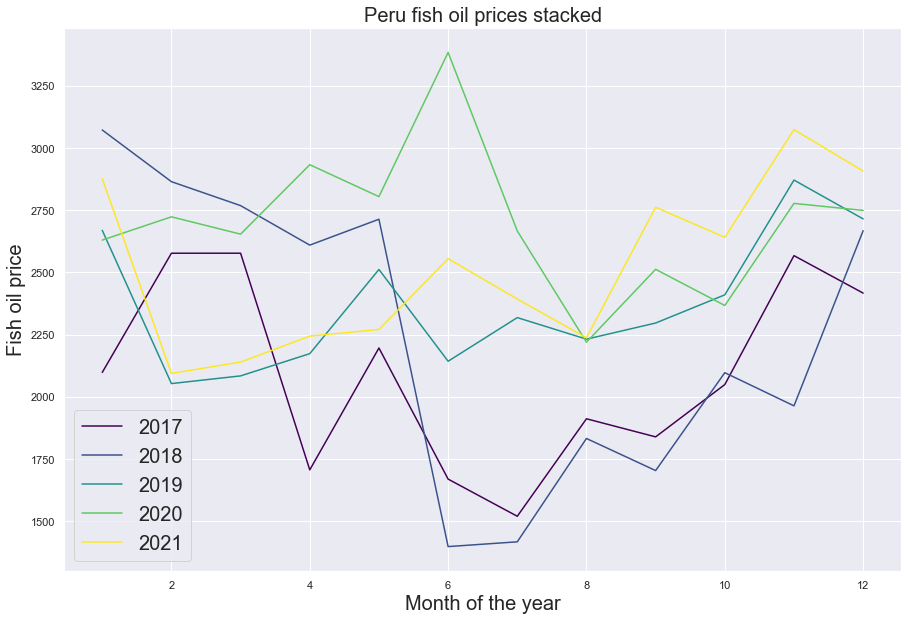

In [136]:
plt.figure(figsize=(15,10))
sns.lineplot(x="month",y="peru_price",data=graph,hue="year",palette="viridis")
plt.ylabel("Fish oil price", fontsize=20)
plt.xlabel("Month of the year", fontsize=20)
plt.legend(fontsize=20)
plt.title("Peru fish oil prices stacked", fontsize=20)
plt.show()

In [ ]:
df.set_index("date", inplace = True)

In [ ]:
df = df[::-1]
df.drop(["year","month"],axis = 1, inplace = True)
df.head()

peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
date                                                                        
2003-01-01       499.1        623.72     639.75      970.03        540.72   
2003-02-01       449.8        585.76     629.46     1016.45        522.43   
2003-03-01       589.4        551.92     620.43     1039.32        522.52   
2003-04-01       636.1        557.22     601.92     1064.23        540.90   
2003-05-01       414.2        607.17     630.09     1147.41        549.24   

            sunflower_oil  peru_temperature  peru_precipitation  \
date                                                              
2003-01-01          612.0             20.85              179.45   
2003-02-01          595.0             20.83              220.07   
2003-03-01          565.0             20.65              203.28   
2003-04-01          578.0             19.64              143.62   
2003-05-01          595.0             19.05              161.21   

            peru_fish_production  fish_human_consumption  \
date                                                       
2003-01-01                  1.19                   40.24   
2003-02-01                  1.42                   24.69   
2003-03-01                  1.28                   24.97   
2003-04-01                  1.18                   23.15   
2003-05-01                  1.44                   30.91   

            fish_industrial_consumption     gdp  fish_oil_export  \
date                                                               
2003-01-01                        39.69   32.79            10.08   
2003-02-01                        80.92   27.52            16.85   
2003-03-01                        66.73   27.33             1.43   
2003-04-01                      1281.71  131.75             0.64   
2003-05-01                      1088.91  116.35            37.55   

            transporation_FOB  fishoil_utilization_indicators  
date                                                           
2003-01-01               5.03                            1.36  
2003-02-01               7.58                            2.71  
2003-03-01               0.84                            2.44  
2003-04-01               0.41                           44.74  
2003-05-01              15.55                           37.58

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2003-01-01 to 2021-12-01
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   peru_price                      228 non-null    float64
 1   rapeseed_oil                    228 non-null    float64
 2   fish_meal                       228 non-null    float64
 3   peanut_oil                      228 non-null    float64
 4   soyabean_oil                    228 non-null    float64
 5   sunflower_oil                   228 non-null    float64
 6   peru_temperature                228 non-null    float64
 7   peru_precipitation              228 non-null    float64
 8   peru_fish_production            228 non-null    float64
 9   fish_human_consumption          228 non-null    float64
 10  fish_industrial_consumption     228 non-null    float64
 11  gdp                             228 non-null    float64
 12  fish_oil_export  

### Plot Series

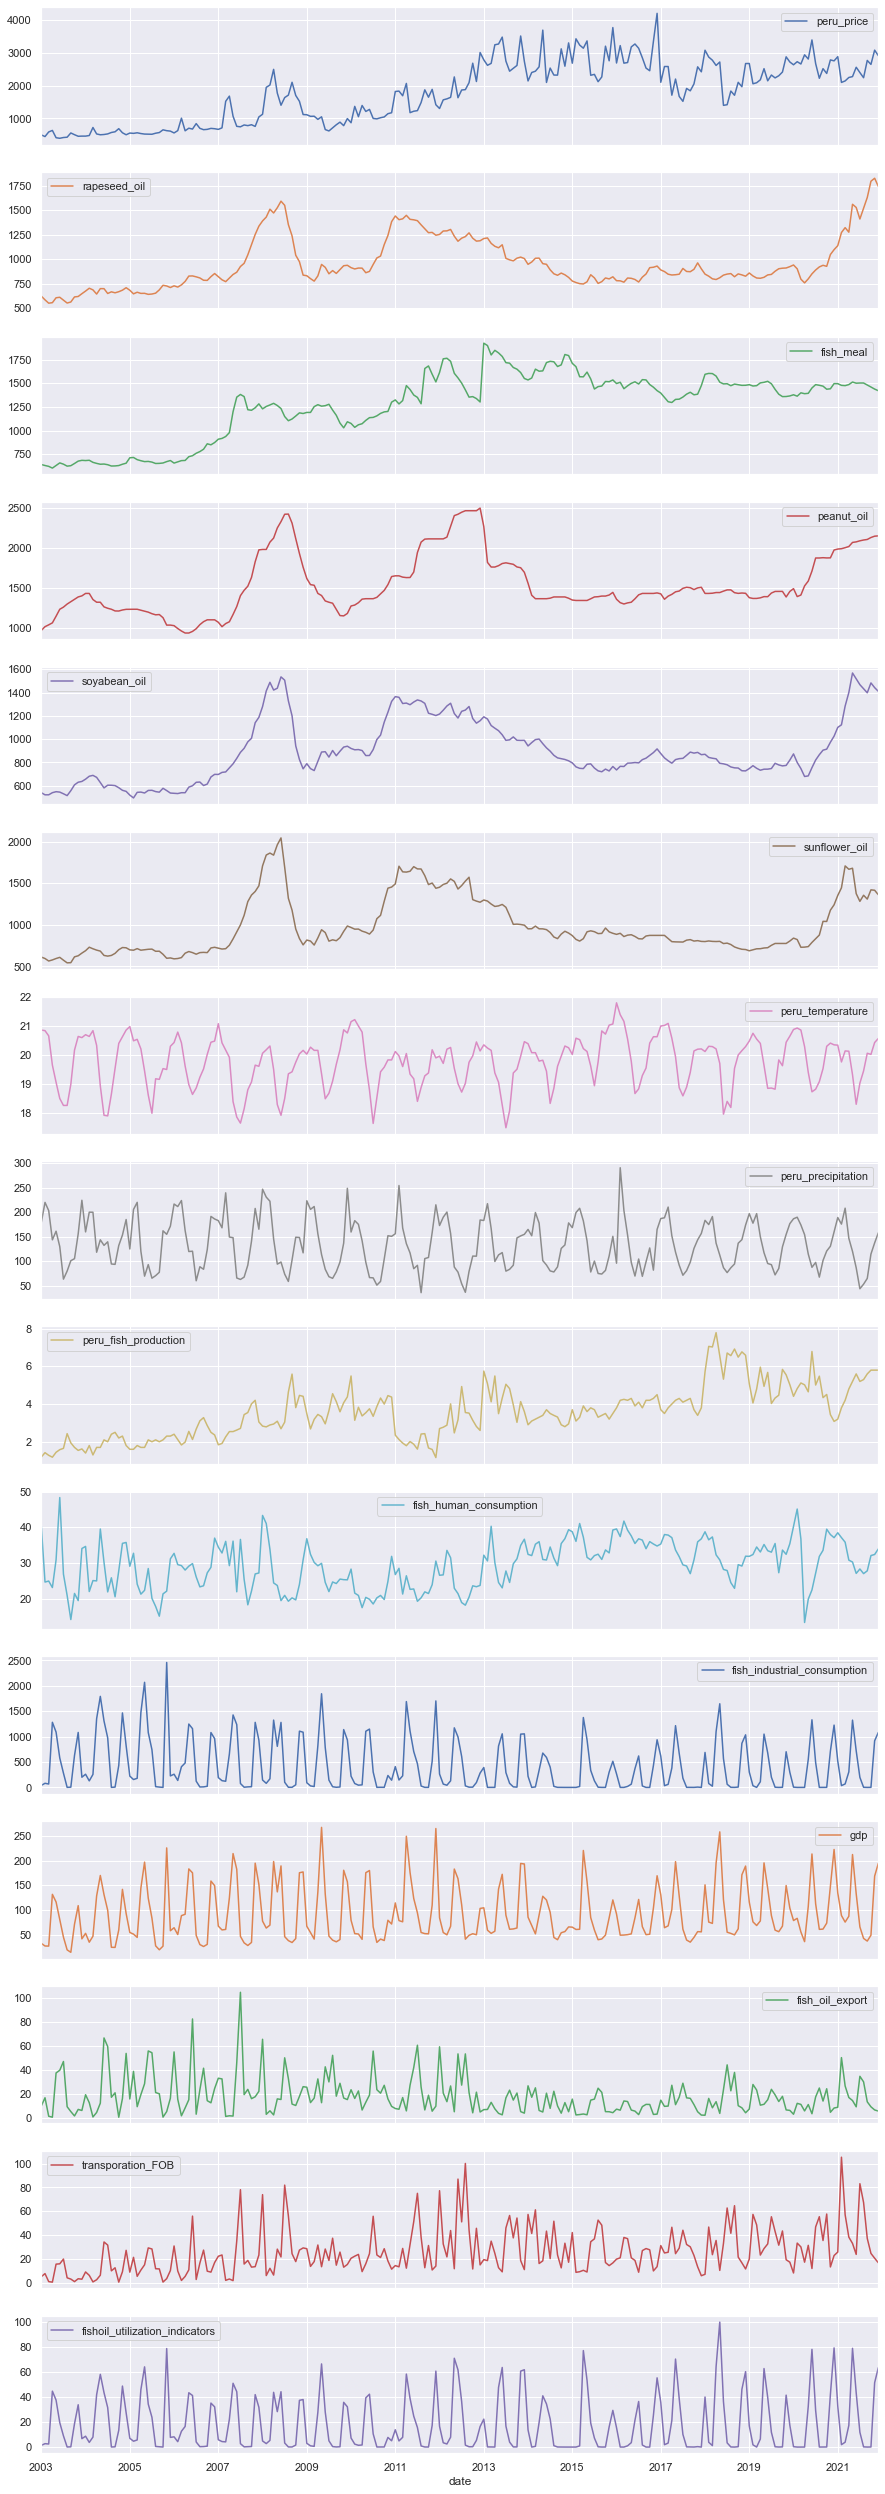

In [ ]:
df.plot(subplots=True, figsize=(15,45));

### EDA

### Correlation pair wise

<Figure size 3600x3600 with 0 Axes>

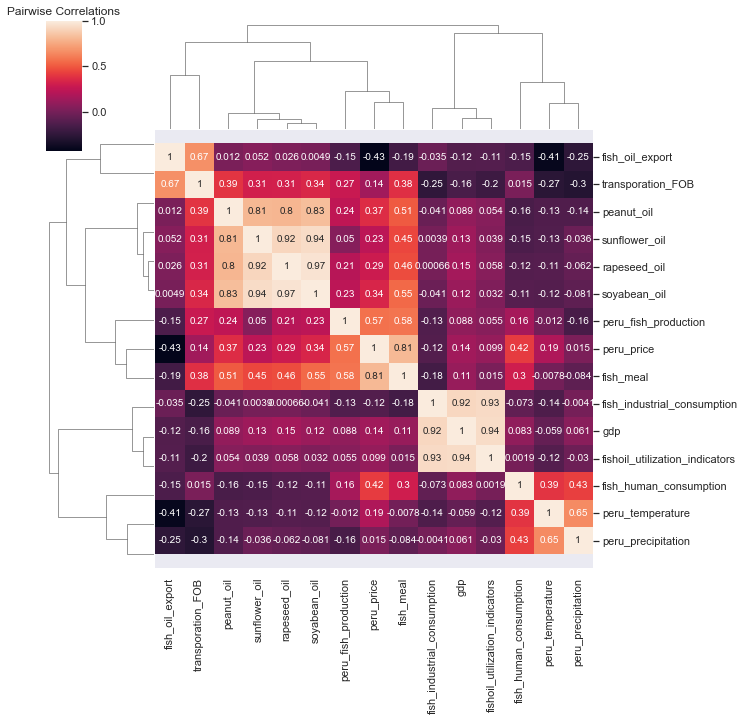

In [ ]:
plt.figure(figsize=(50,50))
g = sns.clustermap(df.corr(), annot=True,annot_kws={"fontsize":10})
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pairwise Correlations')
plt.show()

### Testing Causation using Granger’s Causality Test

In [ ]:
'''
The Granger causality test is a statistical hypothesis test for determining
whether one time series is useful in forecasting another. Ordinarily, 
regressions reflect "mere" correlations, but Clive Granger argued that causality
in economics could be tested for by measuring the ability to predict the
future values of a time series using prior values of another time series.
Since the question of "true causality" is deeply philosophical, and because
of the post hoc fallacy of assuming that one thing preceding another can be
used as a proof of causation, econometricians assert that the Granger test 
finds only "predictive causality". Rather than testing whether Y causes X,
the Granger causality tests whether Y forecasts X.
'''

'\nThe Granger causality test is a statistical hypothesis test for determining\nwhether one time series is useful in forecasting another. Ordinarily, \nregressions reflect "mere" correlations, but Clive Granger argued that causality\nin economics could be tested for by measuring the ability to predict the\nfuture values of a time series using prior values of another time series.\nSince the question of "true causality" is deeply philosophical, and because\nof the post hoc fallacy of assuming that one thing preceding another can be\nused as a proof of causation, econometricians assert that the Granger test \nfinds only "predictive causality". Rather than testing whether Y causes X,\nthe Granger causality tests whether Y forecasts X.\n'

In [ ]:
'''
In simpler terms, the past values of time series (X) do not cause the
other series (Y). So, if the p-value obtained from the test is lesser 
than the significance level of 0.05, then, you can safely reject the null
hypothesis.

The below code implements the Granger’s Causality test for all possible
combinations of each time series in a given dataframe and stores the
p-values of each combination in matrix form.
'''

'\nIn simpler terms, the past values of time series (X) do not cause the\nother series (Y). So, if the p-value obtained from the test is lesser \nthan the significance level of 0.05, then, you can safely reject the null\nhypothesis.\n\nThe below code implements the Granger’s Causality test for all possible\ncombinations of each time series in a given dataframe and stores the\np-values of each combination in matrix form.\n'

In [ ]:
maxlag = 12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

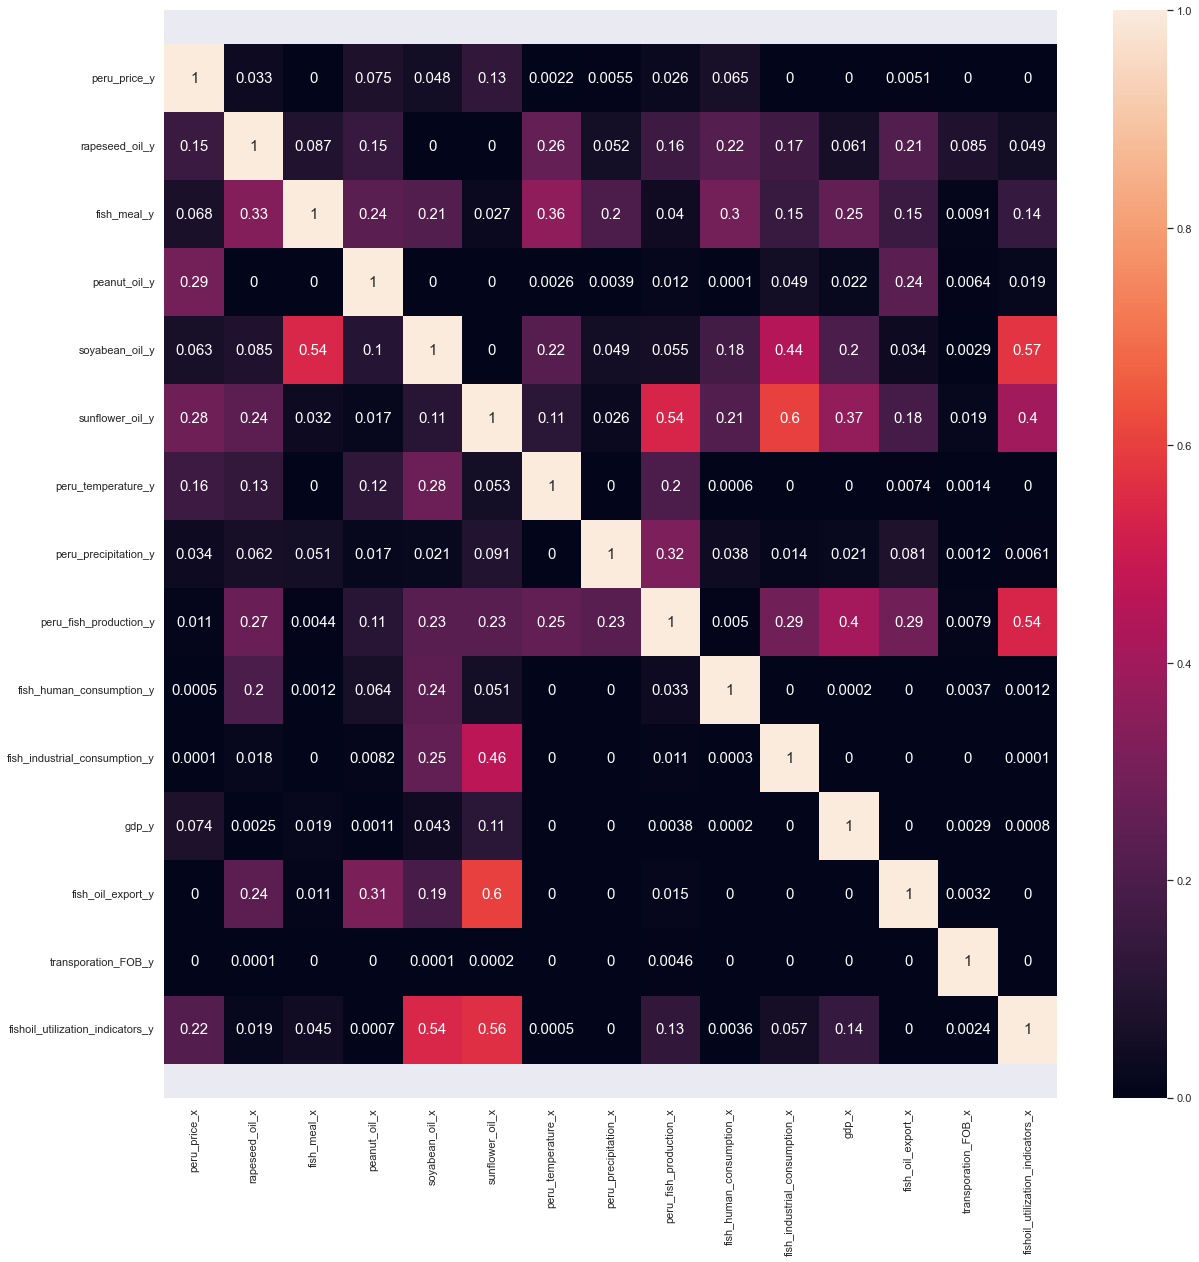

In [ ]:
grangers_df = grangers_causation_matrix(df, variables = df.columns) 

plt.figure(figsize=(20,20))
sns.heatmap(grangers_df, annot=True,annot_kws={"fontsize":15})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()

### Find Significant Pairs in a p-value matrix

In [ ]:
pairs = grangers_df.unstack()
pairs = pairs.sort_values(kind="quicksort")
mask = pairs < 0.05

print("Significan Pairs")
print(pairs[mask])

Significan Pairs
fishoil_utilization_indicators_x  peru_price_y                        0.0000
fish_industrial_consumption_x     transporation_FOB_y                 0.0000
fish_meal_x                       peru_price_y                        0.0000
fish_industrial_consumption_x     fish_oil_export_y                   0.0000
peru_precipitation_x              peru_temperature_y                  0.0000
                                                                       ...  
fish_meal_x                       fishoil_utilization_indicators_y    0.0455
soyabean_oil_x                    peru_price_y                        0.0476
fish_industrial_consumption_x     peanut_oil_y                        0.0490
peru_precipitation_x              soyabean_oil_y                      0.0491
fishoil_utilization_indicators_x  rapeseed_oil_y                      0.0494
Length: 124, dtype: float64


In [ ]:
#Looking at the P-Values in the above table, you can pretty much observe that most the variables (time series) in the system are interchangeably causing each other. This makes this system of multi time series a good candidate for using VAR models to forecast.

### Cointegration Test

In [ ]:
'''
Cointegration test helps to establish the presence of a statistically significant connection between two or more
time series. Cointegration is a statistical property of two or more time-series variables which indicates if a linear 
combination of the variables is stationary.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So it is common to implement the 
cointegration test before starting to build VAR models.
'''

'\nCointegration test helps to establish the presence of a statistically significant connection between two or more\ntime series. Cointegration is a statistical property of two or more time-series variables which indicates if a linear \ncombination of the variables is stationary.\n\nWhen two or more time series are cointegrated, it means they have a long run, statistically significant relationship.\n\nThis is the basic premise on which Vector Autoregression(VAR) models is based on. So it is common to implement the \ncointegration test before starting to build VAR models.\n'

In [ ]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = dataframe.columns 
    pairs = [] 
    for i in range(n):
        for j in range(i+1, n): 
            series1 = dataframe[keys[i]] 
            series2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(series1, series2) 
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    return pvalue_matrix, pairs

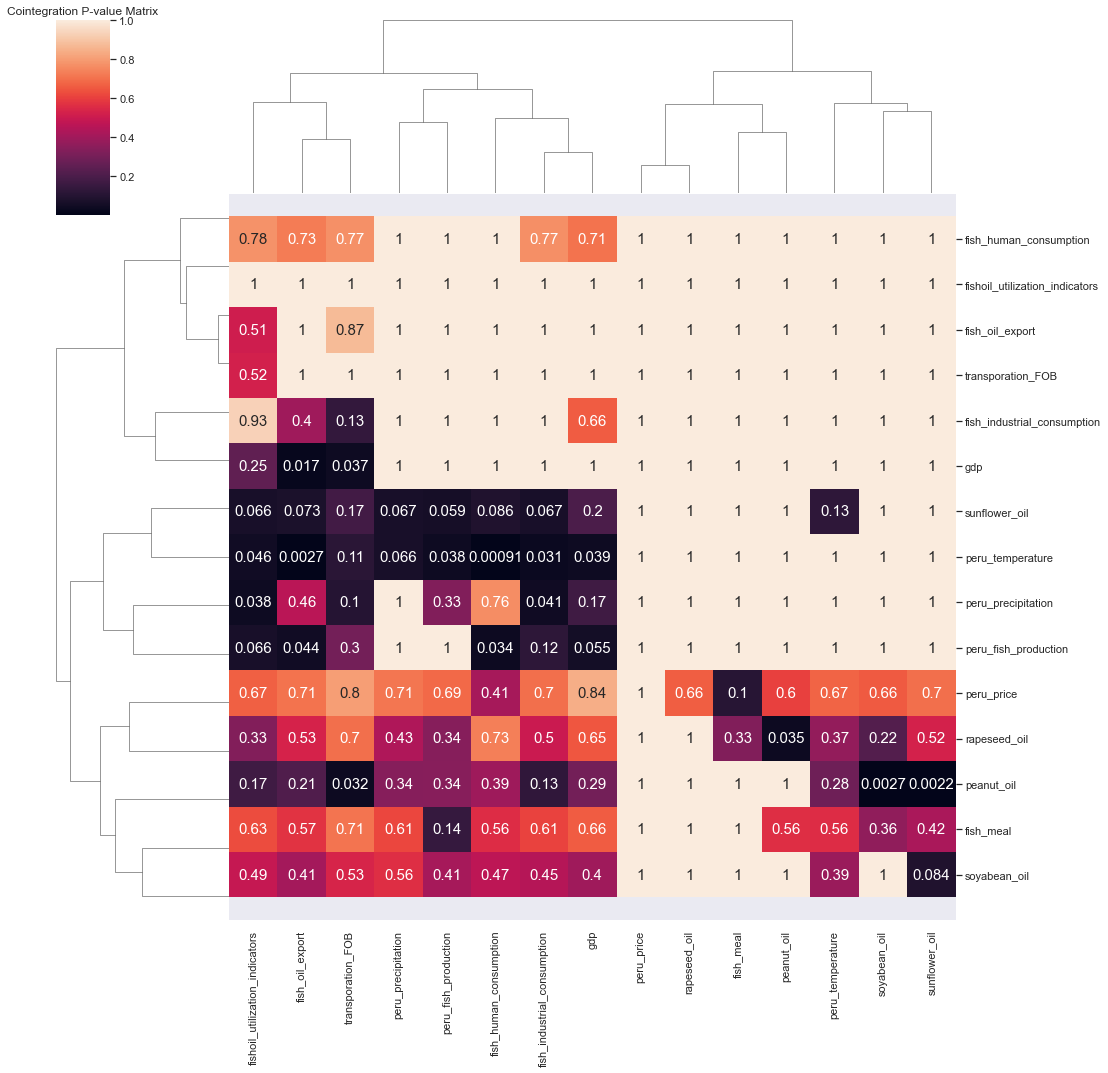

In [ ]:
pvalue_matrix, pairs = find_cointegrated_pairs(df)
coint_pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

g = sns.clustermap(coint_pvalue_matrix_df, xticklabels=df.columns,yticklabels=df.columns, annot=True, 
                   figsize=(15, 15),annot_kws={"fontsize":15})
plt.title('Cointegration P-value Matrix')
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [ ]:
pairs

[('rapeseed_oil', 'peanut_oil', 0.03508992310953115),
 ('peanut_oil', 'soyabean_oil', 0.0026853034312980316),
 ('peanut_oil', 'sunflower_oil', 0.0022140353797906755),
 ('peanut_oil', 'transporation_FOB', 0.03240197333689153),
 ('peru_temperature', 'peru_fish_production', 0.037658686174938255),
 ('peru_temperature', 'fish_human_consumption', 0.0009063385771115584),
 ('peru_temperature', 'fish_industrial_consumption', 0.03121762557531741),
 ('peru_temperature', 'gdp', 0.03872748439670391),
 ('peru_temperature', 'fish_oil_export', 0.0027390230775060703),
 ('peru_temperature', 'fishoil_utilization_indicators', 0.046143079182929356),
 ('peru_precipitation', 'fish_industrial_consumption', 0.040605594773221725),
 ('peru_precipitation', 'fishoil_utilization_indicators', 0.03777624992865804),
 ('peru_fish_production', 'fish_human_consumption', 0.03447484278241159),
 ('peru_fish_production', 'fish_oil_export', 0.0441205963765048),
 ('gdp', 'fish_oil_export', 0.016567320132006052),
 ('gdp', 'tran

In [ ]:
#Peru_price is not pair with anything

### Time Series Decomposition

In [ ]:
for column in df.columns:
    decomp=seasonal_decompose(df[column],period = 12,model="additive", extrapolate_trend="freq")
    df[f"{column}_trend"]=decomp.trend
    df[f"{column}_seasonal"]=decomp.seasonal

In [ ]:
core_column = ['peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil',"soyabean_oil",'sunflower_oil',"peru_temperature","peru_precipitation","peru_fish_production","fish_human_consumption","fish_industrial_consumption","gdp", "fish_oil_export","transporation_FOB","fishoil_utilization_indicators"]
core_column_1 = ['peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil',"soyabean_oil",'sunflower_oil',"peru_temperature","peru_precipitation"]
core_column_2 = ["peru_fish_production","fish_human_consumption","fish_industrial_consumption","gdp", "fish_oil_export","transporation_FOB","fishoil_utilization_indicators"]

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

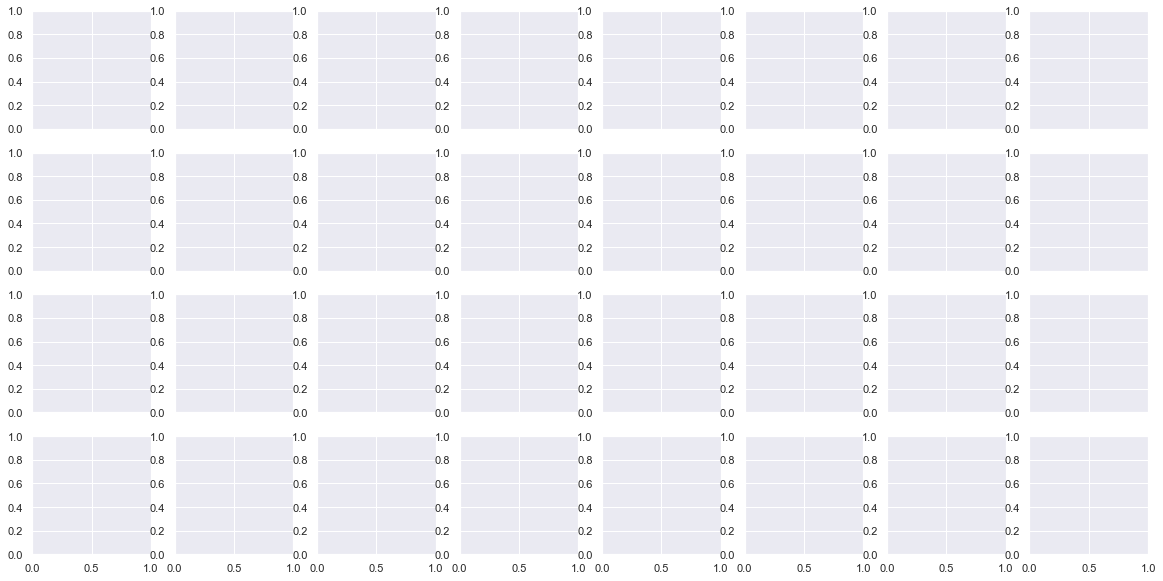

In [ ]:
fig,ax=plt.subplots(ncols=8,nrows=4,sharex=True,figsize=(20,10))
for i, column in enumerate(core_column_1):
    
    res = seasonal_decompose(df[column], freq=12, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('{}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)
plt.tight_layout()
plt.show()

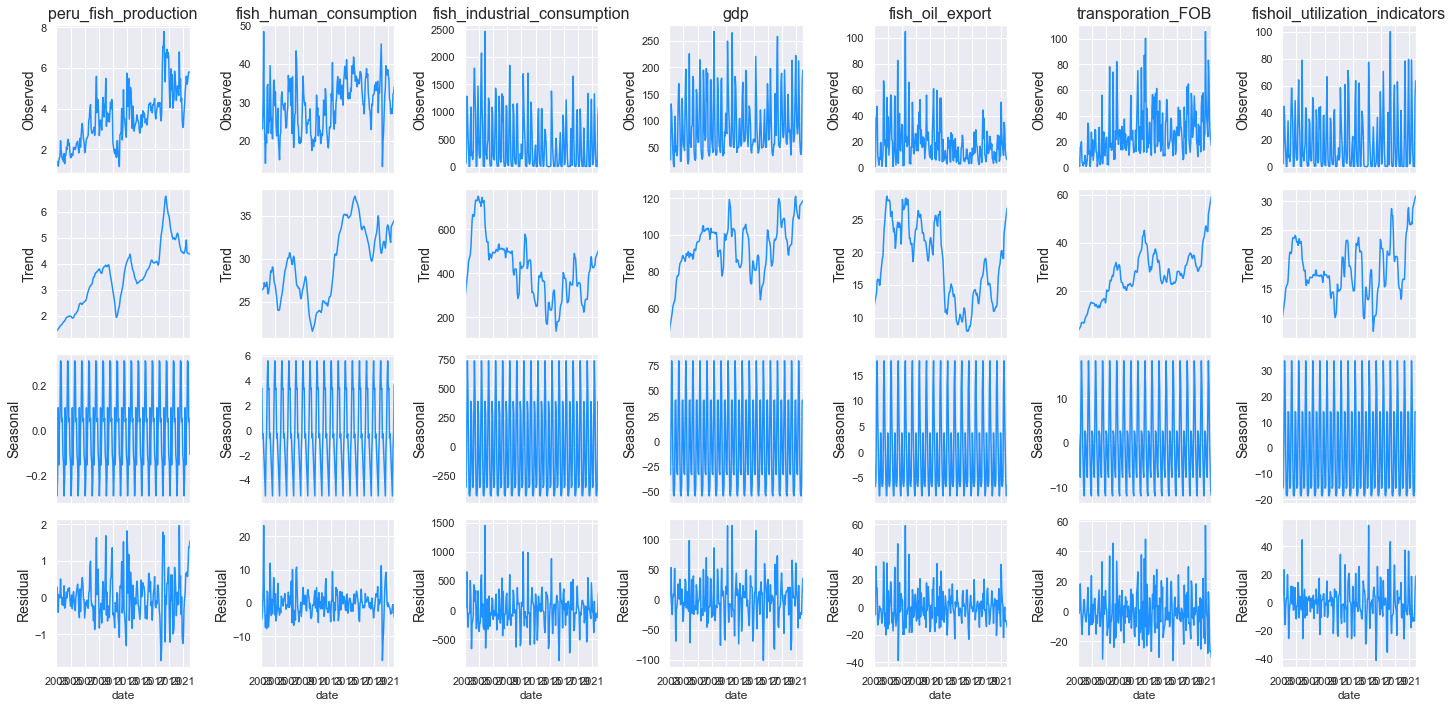

In [ ]:
fig,ax=plt.subplots(ncols=7,nrows=4,sharex=True,figsize=(20,10))
for i, column in enumerate(core_column_2):
    
    res = seasonal_decompose(df[column], freq=12, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('{}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)
plt.tight_layout()
plt.show()

### Calculating correlation between variables based on seasonality

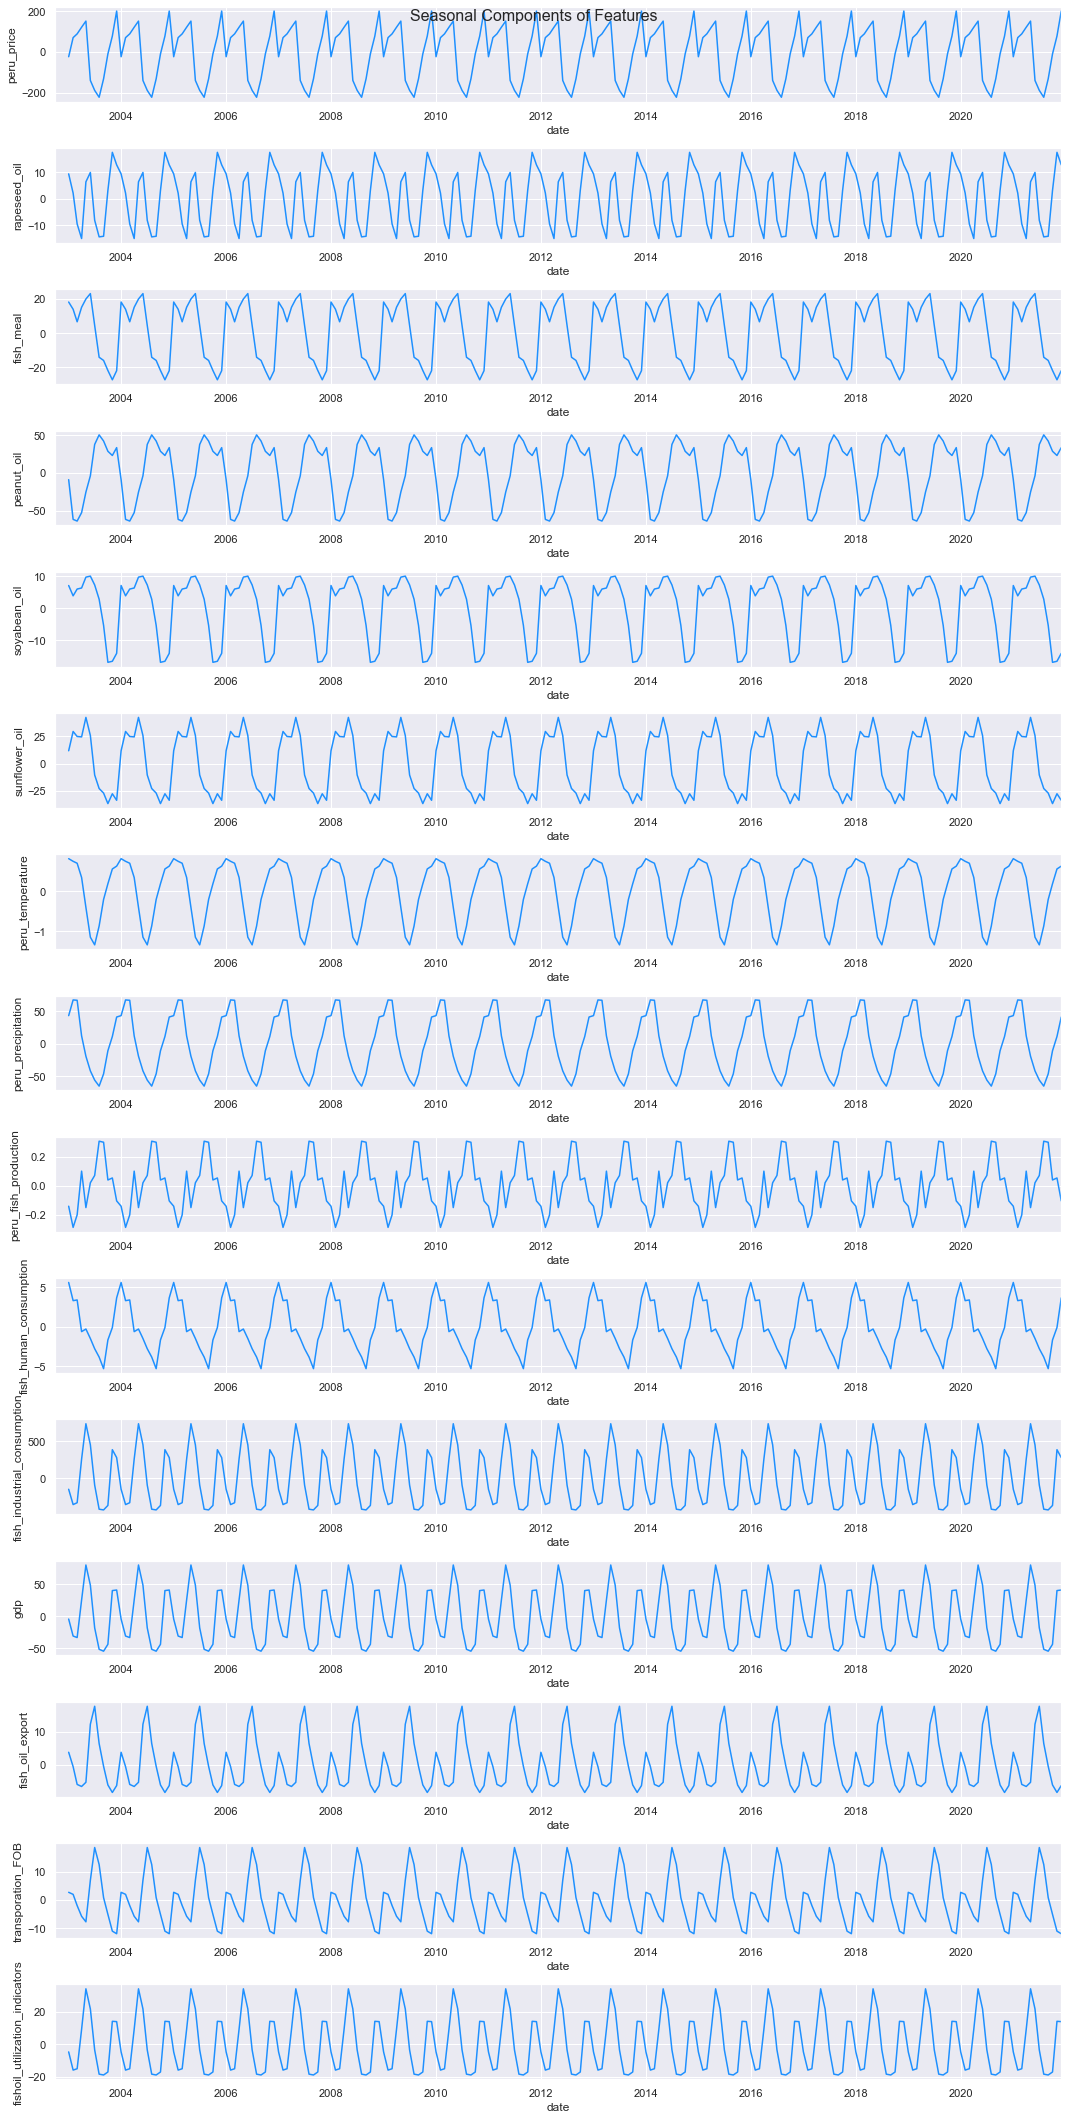

In [ ]:
f, ax = plt.subplots(nrows=15, ncols=1, figsize=(15, 30))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_column):
    sns.lineplot(x=df.index, y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue')
    ax[i].set_ylabel(ylabel=column, fontsize=12)
    ax[i].set_xlim([date(2002, 10, 1), date(2021, 12,1 )])
    
plt.tight_layout()
plt.show()

In [ ]:
'''
From above seasonality plot we could see following things:
1)Fish oil Peru Price - Price is maximum in November
                         Price is minimum around August
                        Increase in price is seen from January to June
2)Rapeseed Oil Price - Price is maximum in November
                        Price is minimum in March
3)Fish Meal Price- Price is maximum in Jan and June
                   Price is minimum in August
'''

'\nFrom above seasonality plot we could see following things:\n1)Fish oil Peru Price - Price is maximum in November\n                         Price is minimum around August\n                        Increase in price is seen from January to June\n2)Rapeseed Oil Price - Price is maximum in November\n                        Price is minimum in March\n3)Fish Meal Price- Price is maximum in Jan and June\n                   Price is minimum in August\n'

### Stationarity check

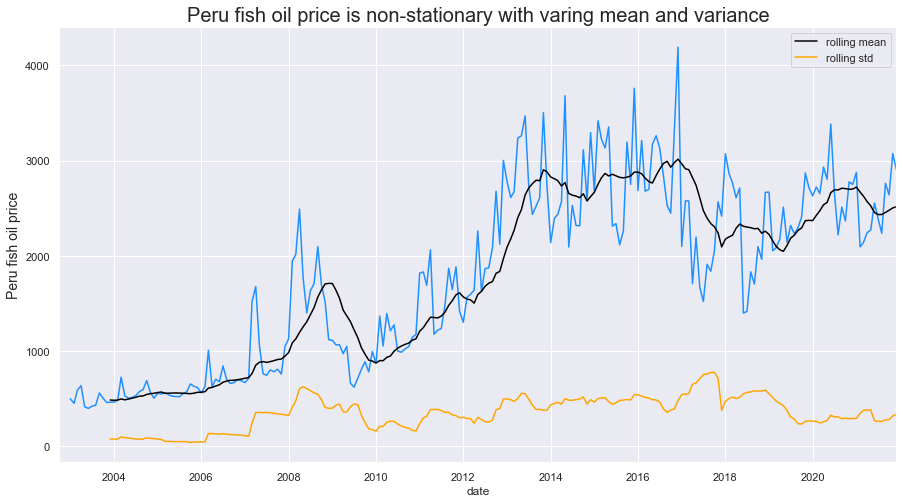

In [ ]:
rolling_window = 12
plt.figure(figsize =(15,8) )
ax = sns.lineplot(x=df.index,y=df["peru_price"],color="dodgerblue")
ax = sns.lineplot(x=df.index,y=df["peru_price"].rolling(rolling_window).mean(),color="black", label="rolling mean")
ax = sns.lineplot(x=df.index, y=df["peru_price"].rolling(rolling_window).std(),color = "orange",label = "rolling std")
ax.set_title("Peru fish oil price is non-stationary with varing mean and variance", fontsize=20)
ax.set_ylabel(ylabel="Peru fish oil price", fontsize=14)
ax.set_xlim([date(2002,10,1),date(2021,12,1)])
plt.show()

#### Using Augmented Dickey-Fuller (ADF) to check stationarity

In [ ]:
#Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

In [ ]:
# Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).
# Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).
# If the null hypothesis can be rejected, we can conclude that the time series is stationary.

In [ ]:
sm.tsa.stattools.adfuller(df["peru_price"])

(-1.6366090773053894,
 0.46403319232067197,
 4,
 223,
 {'1%': -3.460018927623594,
  '5%': -2.8745897386146817,
  '10%': -2.57372514086348},
 3121.9602240933687)

In [ ]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df["peru_price"])[1])

Diskey-Fuller test: p=0.464033


In [ ]:
#Since p value obtained from AD fuller test is above the significant level of 5% therefore we currently have a non-stationary data 

In [ ]:
#checking ADfuller test for all the features in the dataframe and marking them acording to the color

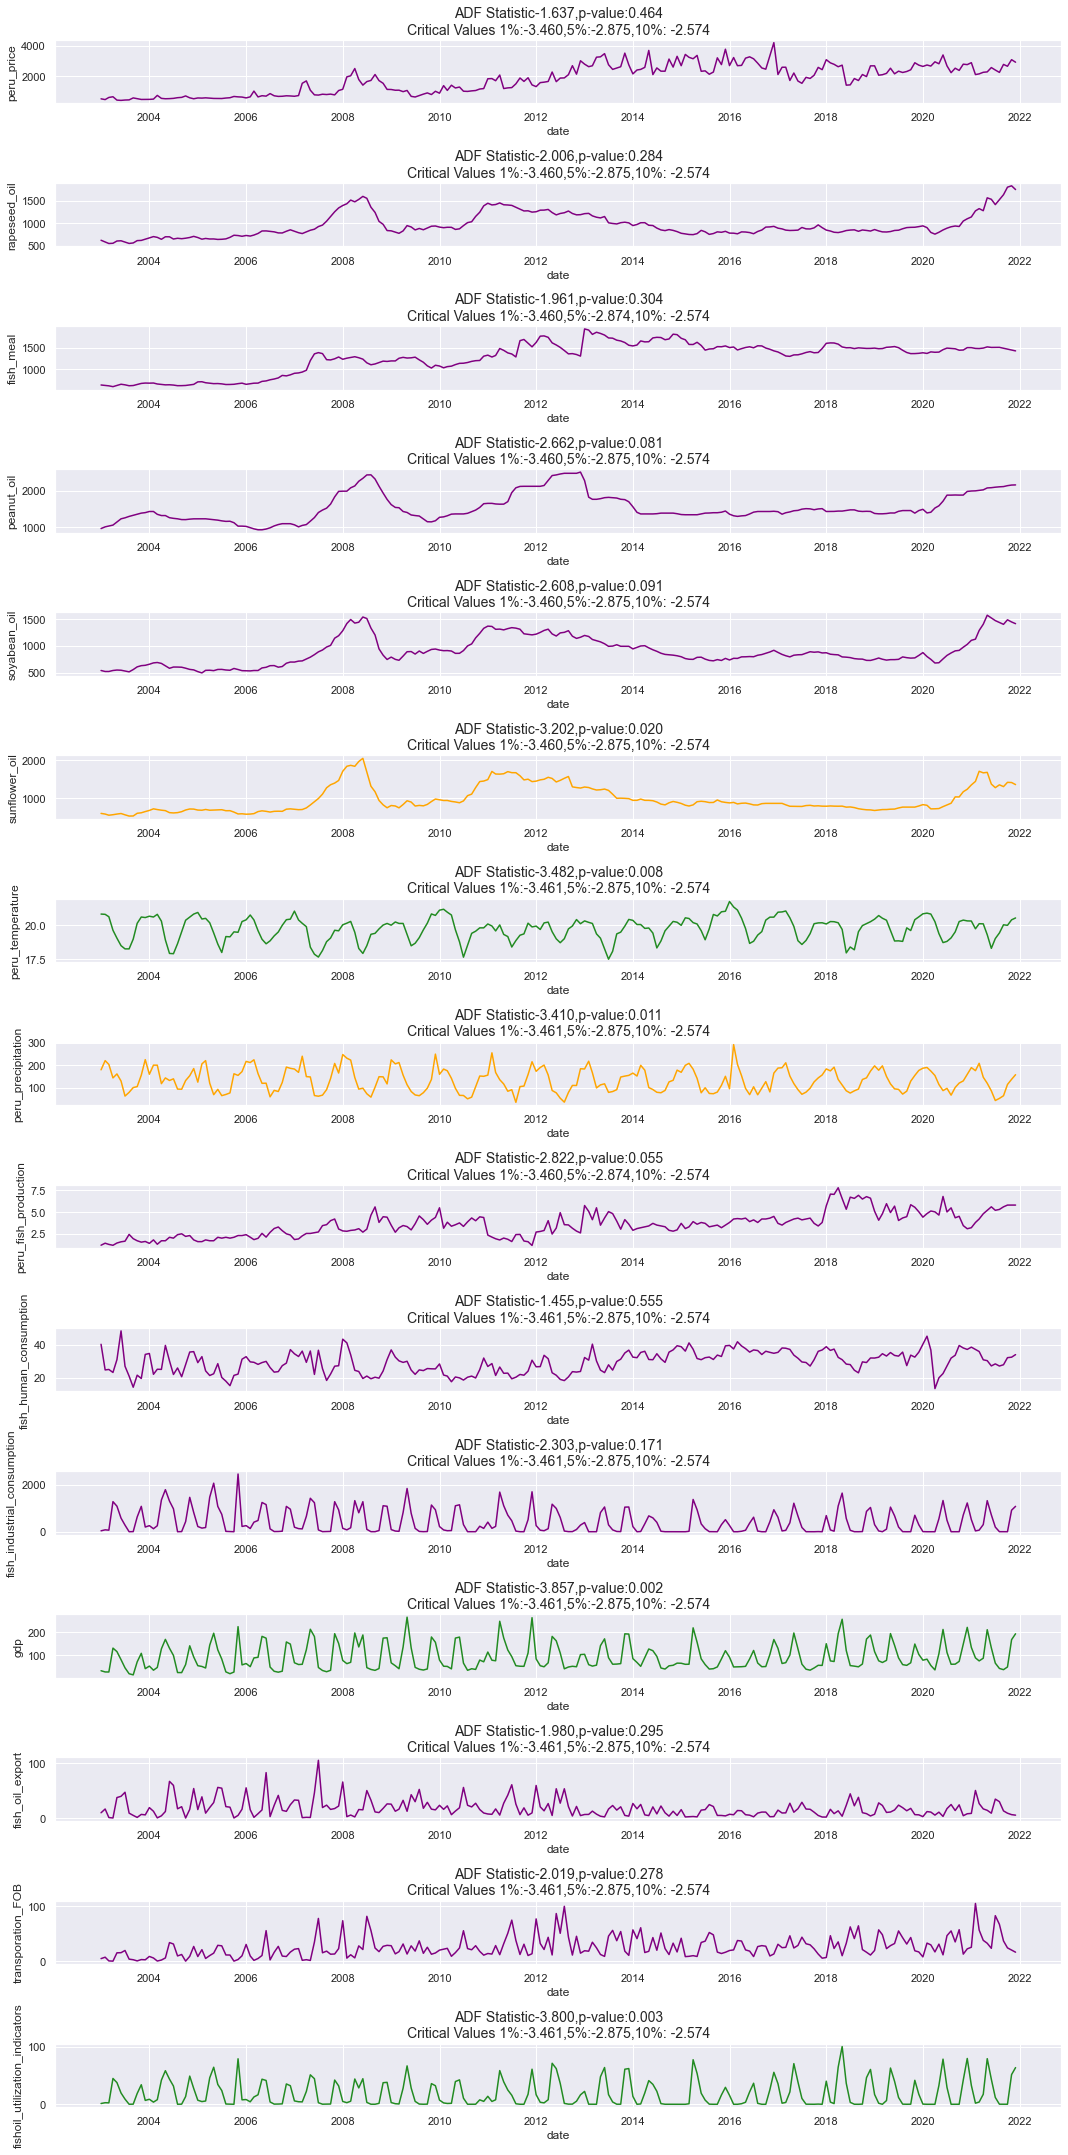

In [ ]:
""""
Unit roots are a cause for non-stationarity.

    Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

    Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

Two conditions are getting checked

1) the null hypothesis can be rejected if the p-value is below a set significance level.
   The defaults significance level is 5%
2) the null hypothesis can be rejects if the test statistic is less than the critical value
On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

    **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

    **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

"""""
f,ax=plt.subplots(nrows=15,ncols=1,figsize=(15,30))
def visualize_adfuller_results(series,title,ax):
    results = adfuller(series)
    significance_level = 0.05
    adf_stat = results[0]
    p_val=results[1]
    crit_val_1=results[4]["1%"]
    crit_val_5=results[4]["5%"]
    crit_val_10=results[4]["10%"]
    
    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = "forestgreen"
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = "orange"
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = "red"
    else:
        linecolor = "purple"
    sns.lineplot(x=df.index,y = series, ax = ax,color = linecolor)
    ax.set_title(f'ADF Statistic{adf_stat:0.3f},p-value:{p_val:0.3f}\nCritical Values 1%:{crit_val_1:0.3f},5%:{crit_val_5:0.3f},10%: {crit_val_10:0.3f}',fontsize=14)
    ax.set_ylabel(ylabel=title,fontsize=12)
#visualize_adfuller_results(df["peru_price"].values, "Peru Fish Oil Price", ax[0,0])
for i, column in enumerate(core_column):
    visualize_adfuller_results(df[column].values, str(column) , ax[i])   
plt.tight_layout()
plt.show()

In [ ]:
# from the above figure we could see that only peru tempertature,gdp and fish_oil_utilization data are stationary,
#so for rest of the data features we need to transform it so they also become stationary.

In [ ]:
df = df[core_column]
df

peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
date                                                                        
2003-01-01       499.1        623.72     639.75      970.03        540.72   
2003-02-01       449.8        585.76     629.46     1016.45        522.43   
2003-03-01       589.4        551.92     620.43     1039.32        522.52   
2003-04-01       636.1        557.22     601.92     1064.23        540.90   
2003-05-01       414.2        607.17     630.09     1147.41        549.24   
...                ...           ...        ...         ...           ...   
2021-08-01      2237.2       1519.19    1504.12     2102.29       1433.94   
2021-09-01      2761.9       1629.14    1483.27     2109.02       1398.75   
2021-10-01      2641.1       1795.17    1461.66     2133.67       1483.52   
2021-11-01      3074.3       1825.34    1439.66     2150.21       1442.96   
2021-12-01      2907.3       1742.50    1422.52     2154.06       1411.21   

            sunflower_oil  peru_temperature  peru_precipitation  \
date                                                              
2003-01-01         612.00             20.85              179.45   
2003-02-01         595.00             20.83              220.07   
2003-03-01         565.00             20.65              203.28   
2003-04-01         578.00             19.64              143.62   
2003-05-01         595.00             19.05              161.21   
...                   ...               ...                 ...   
2021-08-01        1355.69             19.44               53.05   
2021-09-01        1309.52             20.05               64.80   
2021-10-01        1420.53             20.01              114.61   
2021-11-01        1415.62             20.42              137.36   
2021-12-01        1361.83             20.56              157.86   

            peru_fish_production  fish_human_consumption  \
date                                                       
2003-01-01                  1.19                   40.24   
2003-02-01                  1.42                   24.69   
2003-03-01                  1.28                   24.97   
2003-04-01                  1.18                   23.15   
2003-05-01                  1.44                   30.91   
...                          ...                     ...   
2021-08-01                  5.30                   27.05   
2021-09-01                  5.60                   27.83   
2021-10-01                  5.80                   32.12   
2021-11-01                  5.80                   32.41   
2021-12-01                  5.80                   33.97   

            fish_industrial_consumption     gdp  fish_oil_export  \
date                                                               
2003-01-01                        39.69   32.79            10.08   
2003-02-01                        80.92   27.52            16.85   
2003-03-01                        66.73   27.33             1.43   
2003-04-01                      1281.71  131.75             0.64   
2003-05-01                      1088.91  116.35            37.55   
...                                 ...     ...              ...   
2021-08-01                         2.53   42.79            30.12   
2021-09-01                         0.12   37.47            13.46   
2021-10-01                         1.26   49.26             9.30   
2021-11-01                       917.78  168.51             6.69   
2021-12-01                      1082.07  194.30             5.75   

            transporation_FOB  fishoil_utilization_indicators  
date                                                           
2003-01-01               5.03                            1.36  
2003-02-01               7.58                            2.71  
2003-03-01               0.84                            2.44  
2003-04-01               0.41                           44.74  
2003-05-01              15.55                           37.58  
...                     

## Transforming data to make it stationary

#### Using differentiation technique

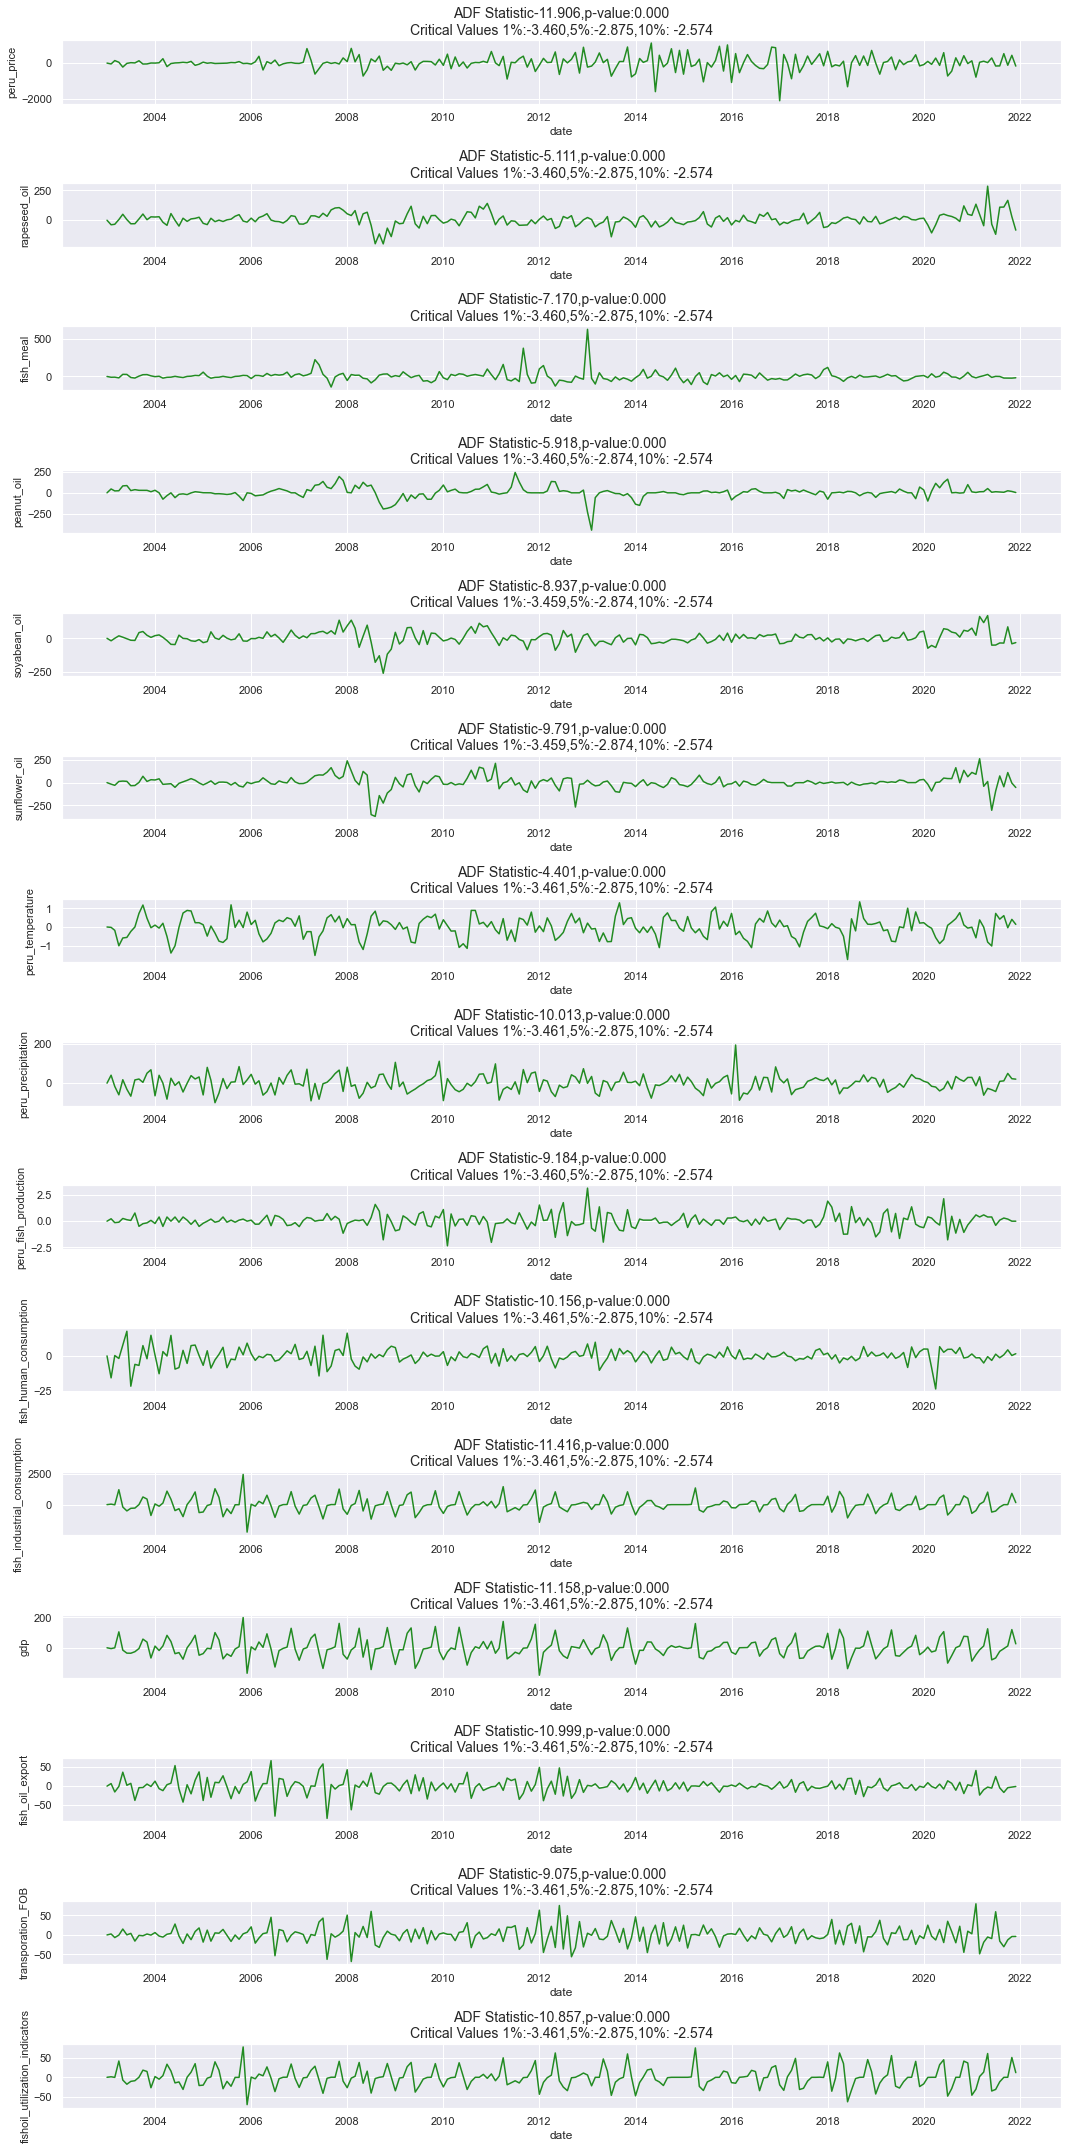

In [ ]:
for i in df.columns:
    df[i] = np.append([0], np.diff(df[i]))
f, ax = plt.subplots(nrows=15, ncols=1, figsize=(15, 30))
for i,j in enumerate(df.columns):
    visualize_adfuller_results(df[j], "differenced", ax[i])
    ax[i].set_ylabel(ylabel=j , fontsize=11)
plt.tight_layout()
plt.show()  

In [ ]:
df.columns

Index(['peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil', 'soyabean_oil',
       'sunflower_oil', 'peru_temperature', 'peru_precipitation',
       'peru_fish_production', 'fish_human_consumption',
       'fish_industrial_consumption', 'gdp', 'fish_oil_export',
       'transporation_FOB', 'fishoil_utilization_indicators'],
      dtype='object')

### Autocorrelation Analysis

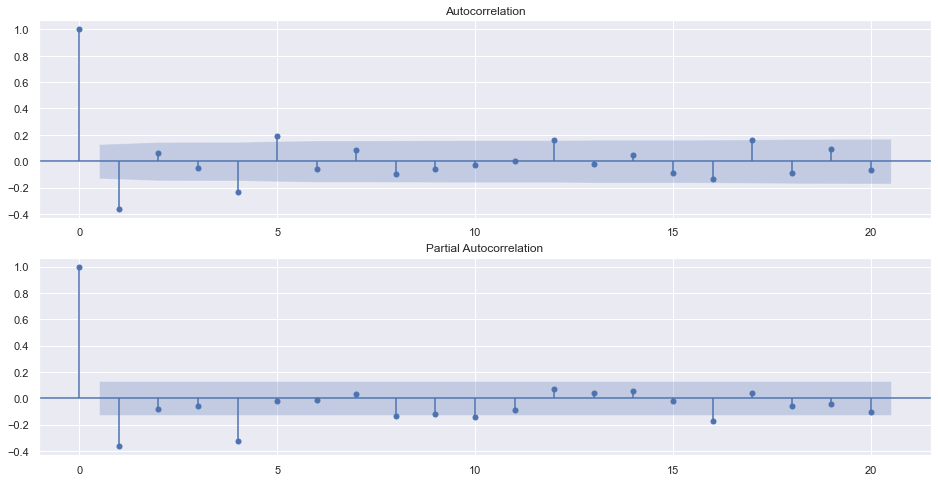

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(df['peru_price'], lags=20, ax=ax[0])
plot_pacf(df['peru_price'], lags=20, ax=ax[1])
plt.show()

####  Split the Series into Training and Testing Data

In [ ]:
df_uni = df["peru_price"]
df_uni.head()

date
2003-01-01      0.0
2003-02-01    -49.3
2003-03-01    139.6
2003-04-01     46.7
2003-05-01   -221.9
Name: peru_price, dtype: float64

In [ ]:
train_end = datetime(2017,12,1)
test_end = datetime(2021,12,1)
df_train = df_uni[:train_end]
df_test = df_uni[train_end + timedelta(days=1):test_end]
df_train.tail()

date
2017-08-01    391.9
2017-09-01    -72.7
2017-10-01    210.3
2017-11-01    518.2
2017-12-01   -150.6
Name: peru_price, dtype: float64

### Using Auto Arima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model_auto = pm.auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                                    # frequency of series
                      max_d=1,           # let model determine 'd'
                      seasonal=True,m=12,
                      start_P=0,start_Q=0,max_P=5,
                      max_Q=5,max_D=1,  
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2689.576, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2655.108, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2652.841, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2687.692, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2656.869, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2644.801, Time=0.63 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2650.653, Time=0.36 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=2645.110, Time=1.41 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2644.083, Time=1.82 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2650.130, Time=0.72 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=2645.516, Time=2.30 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=2642.642, Time=3.84 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=2640.805, Time=2.92 sec
 ARIMA(0,0,1)(0,0,4)[12] intercept   : AIC=2642.649, Time=5.55 sec
 ARIMA(0,0,1)(1,0,4

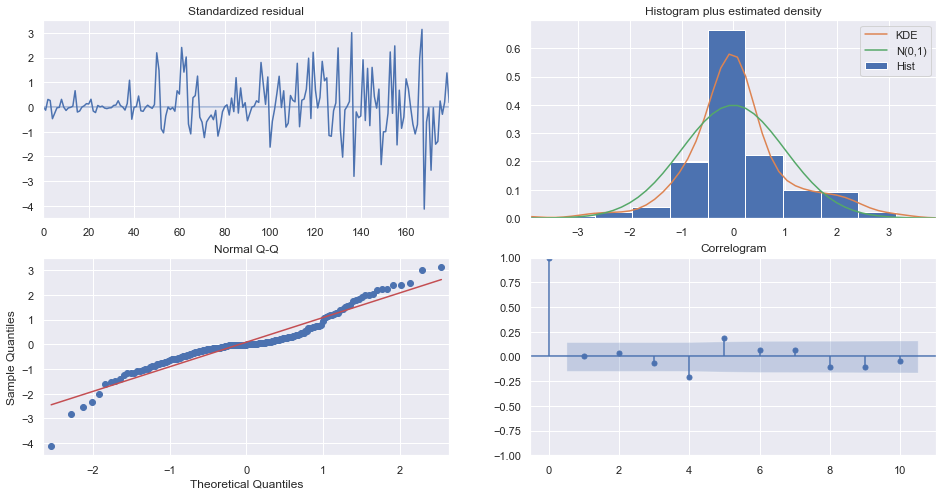

In [ ]:
model_auto.plot_diagnostics(figsize=(16,8))
plt.show()

### Rolling Window

In [ ]:
my_order = (0,0,1)
my_seasonal_order = (0, 0, 3, 12)
rolling_predictions = df_test.copy()
for train_end in df_test.index:
    train_data = df_uni[:train_end-timedelta(days=1)]
    op_model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    op_model_fit = op_model.fit()
    pred = op_model_fit.forecast()
    rolling_predictions[train_end] = pred

In [ ]:
rolling_residuals = df_test - rolling_predictions

Text(0, 0.5, 'Error')

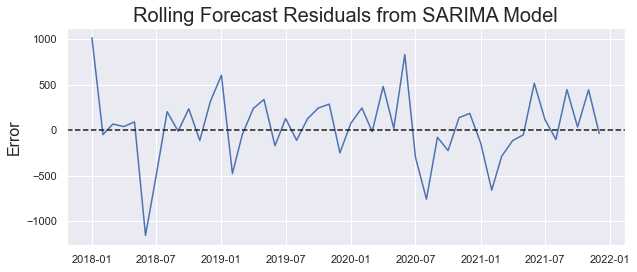

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

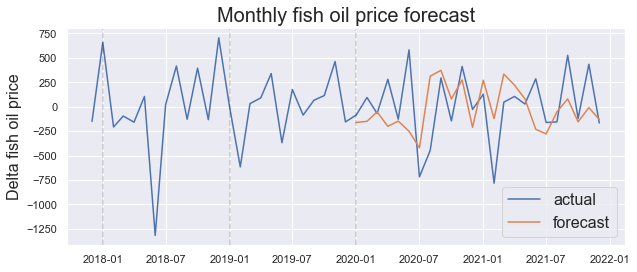

In [147]:
plt.figure(figsize=(10,4))

plt.plot(df_uni[datetime(2017,12,1):])
plt.plot(rolling_predictions)

plt.legend(('actual', 'forecast'), fontsize=16)

plt.title('Monthly fish oil price forecast', fontsize=20)
plt.ylabel('Delta fish oil price', fontsize=16)
for year in range(2018,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [157]:
count_correct = 0
count_total = len(df_uni[datetime(2020,1,1):])

for index in range(count_total):
    if (df_uni[datetime(2020,1,1):][index] < 0) and (rolling_predictions[index] < 0):
        count_correct += 1

    if (df_uni[datetime(2020,1,1):][index] > 0) and (rolling_predictions[index] > 0):
        count_correct += 1

print("Accuracy: ", count_correct / count_total)

Accuracy:  0.7083333333333334


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 378.8965381320264


In [ ]:
def mape(actual,forecast):
    APE=[]
    for day in range(len(actual)):
        per_err = abs((actual[day] - forecast[day]) / actual[day])
        APE.append(per_err)
    MAPE = sum(APE)/len(APE)
    return (MAPE)

In [ ]:
MAPE = mape(df_test,rolling_predictions)
print("Mean Absolute Percentage Error:", MAPE )

Mean Absolute Percentage Error: 10.10783075457383


In [ ]:
nobs = 48
df_original=df_original[::-1]
df_forecast = rolling_predictions + df_original["peru_price"].iloc[-nobs-1]
df_forecast

date
2018-01-01    2057.197184
2018-02-01    2258.340019
2018-03-01    2253.893837
2018-04-01    2218.936401
2018-05-01    2430.660695
2018-06-01    2257.919442
2018-07-01    2938.396684
2018-08-01    2629.936483
2018-09-01    2299.457659
2018-10-01    2575.958983
2018-11-01    2396.959982
2018-12-01    2804.302321
2019-01-01    1814.562648
2019-02-01    2278.196164
2019-03-01    2494.618784
2019-04-01    2267.964741
2019-05-01    2418.110258
2019-06-01    2219.550239
2019-07-01    2464.927935
2019-08-01    2441.298366
2019-09-01    2355.278021
2019-10-01    2287.580145
2019-11-01    2592.497452
2019-12-01    2510.598525
2020-01-01    2255.429269
2020-02-01    2266.777110
2020-03-01    2363.710113
2020-04-01    2216.000275
2020-05-01    2268.961507
2020-06-01    2165.592832
2020-07-01    1996.150764
2020-08-01    2728.235681
2020-09-01    2788.030725
2020-10-01    2495.832918
2020-11-01    2689.877320
2020-12-01    2204.765655
2021-01-01    2687.004805
2021-02-01    2294.035599
2021-03

### Different train test split

In [ ]:
train_end = datetime(2019,12,1)
test_end = datetime(2021,12,1)
df_train = df_uni[:train_end]
df_test = df_uni[train_end + timedelta(days=1):test_end]
df_train.tail()

date
2019-08-01    -86.6
2019-09-01     64.8
2019-10-01    113.3
2019-11-01    461.4
2019-12-01   -156.1
Name: peru_price, dtype: float64

In [ ]:

my_order = (0,0,1)
my_seasonal_order = (0, 0, 3, 12)
rolling_predictions = df_test.copy()
for train_end in df_test.index:
    train_data = df_uni[:train_end-timedelta(days=1)]
    op_model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    op_model_fit = op_model.fit()
    pred = op_model_fit.forecast()
    rolling_predictions[train_end] = pred

In [ ]:
rolling_residuals = df_test - rolling_predictions

Text(0, 0.5, 'Error')

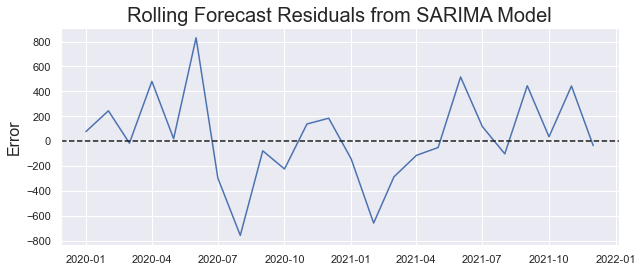

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

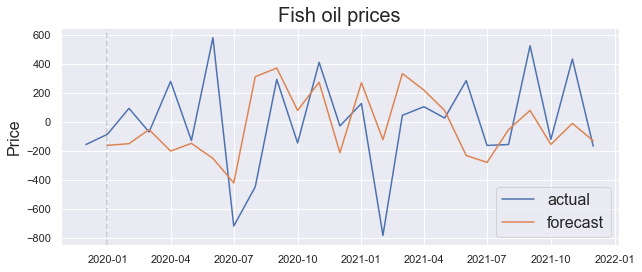

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df_uni[datetime(2019,12,1):])
plt.plot(rolling_predictions)

plt.legend(('actual', 'forecast'), fontsize=16)

plt.title('Fish oil prices', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(2020,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 353.6175248865448


In [ ]:
MAPE = mape(df_test,rolling_predictions)
print("Mean Absolute Percentage Error:", MAPE )

Mean Absolute Percentage Error: 1.4489481784589875


In [ ]:
nobs = 24
df_original=df_original[::-1]
df_forecast = rolling_predictions + df_original["peru_price"].iloc[-nobs-1]
df_forecast

date
2020-01-01    2553.729269
2020-02-01    2565.077110
2020-03-01    2662.010113
2020-04-01    2514.300275
2020-05-01    2567.261507
2020-06-01    2463.892832
2020-07-01    2294.450764
2020-08-01    3026.535681
2020-09-01    3086.330725
2020-10-01    2794.132918
2020-11-01    2988.177320
2020-12-01    2503.065655
2021-01-01    2985.304805
2021-02-01    2592.335599
2021-03-01    3048.176959
2021-04-01    2934.492088
2021-05-01    2793.496012
2021-06-01    2483.907033
2021-07-01    2436.230085
2021-08-01    2661.799337
2021-09-01    2794.562975
2021-10-01    2559.921071
2021-11-01    2705.199434
2021-12-01    2584.648808
Name: peru_price, dtype: float64